### Simple input ATRLIF model with integer values only

In [1]:
import sys
#sys.path.append('/home/jovyan/brian2lava')
#sys.path.append('/home/carlo/Entwicklung/Python/brian2lava')
#sys.path.append('/home/francesco/Developing/B2L/brian2lava')
#sys.path.append('/homes/jlubo/brian2lava')

In [2]:
from brian2 import *

In [3]:
# Import Brian2Lava
import brian2lava

# Use included models directory
models_dir=None

# Use external models directory (containing ncProcessModels for Loihi)
# models_dir='/homes/jlubo/brian2lava-models/models'

# Set device, choosing fixed-point representation but switching off F2F conversion
set_device('lava', mode='preset', hardware='CPU', num_repr='fixed', use_f2f=True, models_dir=models_dir) # use preset-model mode with CPU (fixed-pt. representation)

# set_device('runtime')
# # Needed when switching from flexible mode to runtime 
# prefs.codegen.target = 'numpy'
# prefs.codegen.string_expression_target = 'numpy'



BrianLogger.log_level_debug()

Preset models available:

lif_v_input -- /home/francesco/Developing/B2L/brian2lava/brian2lava/preset_mode/lib/model_lib/lif_v_input -- CPU-only
atrlif -- /home/francesco/Developing/B2L/brian2lava/brian2lava/preset_mode/lib/model_lib/atrlif -- CPU-only
probspiker -- /home/francesco/Developing/B2L/brian2lava/brian2lava/preset_mode/lib/model_lib/probspiker -- CPU-only
lif -- /home/francesco/Developing/B2L/brian2lava/brian2lava/preset_mode/lib/model_lib/lif -- CPU-only
lif_rp_v_input -- /home/francesco/Developing/B2L/brian2lava/brian2lava/preset_mode/lib/model_lib/lif_rp_v_input -- CPU-only

These models have been loaded and can be imported from 'brian2lava.preset_mode.model_loader' by their name. Given the currently available models, you might run, for example: 'from brian2lava.preset_mode.model_loader import lif_v_input'.


In [4]:
# Import ATRLIF model
from brian2lava.preset_mode.model_loader import atrlif

In [5]:
# Set seed
seed(1)

# Set defaultclock
defaultclock.dt = 0.5*ms

In [6]:
print(atrlif.equations, type(atrlif.equations))
print(atrlif.conditions)

dj/dt = -j/tau_j : V/s
dr/dt = -r/tau_r : V
dtheta/dt = (theta_0-theta)/tau_theta : V
dv/dt = -v/tau_v + j + bias : V <class 'brian2.equations.equations.Equations'>
{'th': 'v-r > theta', 'rs': ['r = r + 2*theta', 'theta = theta + theta_step']}


LaTeX equations                                                                 
--------------------------------------------------------------------------------


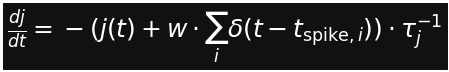

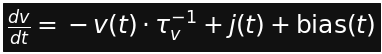

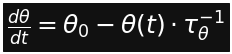

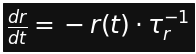

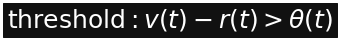

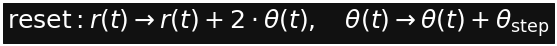



Raw LaTeX equations                                                             
--------------------------------------------------------------------------------
\frac{dj}{dt} = -(j(t) + w\cdot\sum_i \delta(t - t_{\mathrm{spike},i})) \cdot \tau_j^{-1}
\frac{dv}{dt} = -v(t) \cdot \tau_v^{-1} + j(t)+ \mathrm{bias}(t)                
\frac{d\theta}{dt} = \theta_0 - \theta(t) \cdot \tau_\theta^{-1}                
\frac{dr}{dt} = -r(t) \cdot \tau_r^{-1}                                         
\mathrm{threshold} : v(t) - r(t) > \theta(t)                                    
\mathrm{reset} : r(t) \rightarrow r(t) + 2\cdot\theta(t),\quad\theta(t) \rightarrow \theta(t) + \theta_\mathrm{step}


Brian 2 ODEs                                                                    
--------------------------------------------------------------------------------
dj/dt = -j/tau_j : volt/second                                                  
dv/dt = -v/tau_v + j + bias : volt                          

In [7]:
atrlif.show()

In [8]:

# Define parameters (same as for the example in our internal neuron models repo)
N = 3
bias = 3 * mV/ms
tau_j = 1 * ms
tau_v = 1 / 0.4 * ms #10 *   ms # delta_v = dt/tau_v*2^12
tau_theta = 1 / 0.4 * ms #10 *   ms
tau_r = 1 / 0.2 * ms #5 *   ms
theta_0 = 5 *   mV
theta_step = 3.75 * mV

# Transcribe reset conditions (convert list to multiline string)
reset_cond = "\n".join(atrlif.conditions["rs"])

# Add a spike generator group
S = SpikeGeneratorGroup(N, [0, 0], [2, 6]*ms) 

# Add a neuron group (which receives a background input)
P = NeuronGroup(N, atrlif.equations, threshold=atrlif.conditions["th"], reset=reset_cond, method='euler')
P.j = "0 * mV/ms"
P.v = "0 * mV"
P.theta = theta_0
P.r = "0 * mV"

# Add another neuron group (which does not receive a background input)
Q = NeuronGroup(N, atrlif.equations, threshold=atrlif.conditions["th"], reset=reset_cond, method='euler')
#Q.j = "0.1*mV/ms"
Q.v = "0 * mV"
Q.theta = theta_0
Q.r = "0 * mV"

# Add synapses
syn = Synapses(S, Q, model = 'w : volt/second', on_pre='j_post += w')
syn.connect(i=[0], j=[0,1,2])
syn.w = 60 * mV/ms

DEBUG      Creating synapses from group 'spikegeneratorgroup' to group 'neurongroup_1', using pre-defined arrays) [brian2.synapses.synapses]


In [9]:
device = get_device()
device.code_object_class()

brian2.codegen.runtime.numpy_rt.numpy_rt.NumpyCodeObject

In [10]:
# Add monitor for spikes
#sm = SpikeMonitor(P)
spmP = SpikeMonitor(P, variables='v', record=True) # TODO adapt to adaptive-thr.
spmQ = SpikeMonitor(Q, variables='v', record=False) # TODO adapt to adaptive-thr.

# Add monitors for voltage and current
stmPv = StateMonitor(P, variables='v', record=True)
stmPj = StateMonitor(P, variables='j', record=True)
stmPtheta = StateMonitor(P, variables='theta', record=True)
stmPr = StateMonitor(P, variables='r', record=True)
stmQv = StateMonitor(Q, variables='v', record=True)
stmQj = StateMonitor(Q, variables='j', record=True)
stmQtheta = StateMonitor(Q, variables='theta', record=True)
stmQr = StateMonitor(Q, variables='r', record=True)

DEBUG      Monitor _spike_spikemonitor_v not added yet, will add the additional var monitor for v later. [brian2.devices.lava]
WARNING    Setting spike monitor to False is currently working through a trick: indices and spike timings will still be recorded but not saved, so there is no preformance gain from using this setting at the moment. [brian2.devices.lava]


In [11]:
# Run simulation
#run(15*ms)
run(21 * ms)

DEBUG      Updated MagicNetwork to include 21 objects with names neurongroup_1_spike_resetter, statemonitor_1, statemonitor_2, spikegeneratorgroup, neurongroup_1_stateupdater, neurongroup_1_spike_thresholder, statemonitor_6, statemonitor_7, neurongroup_stateupdater, statemonitor_3, statemonitor_4, statemonitor_5, neurongroup_1, synapses_pre, neurongroup_spike_resetter, synapses, spikemonitor, statemonitor, neurongroup_spike_thresholder, neurongroup, spikemonitor_1 [brian2.core.magic.magic_objects]
DEBUG      Preparing network 'magicnetwork' with 21 objects: neurongroup, neurongroup_1, statemonitor, statemonitor_1, statemonitor_2, statemonitor_3, statemonitor_4, statemonitor_5, statemonitor_6, statemonitor_7, synapses, neurongroup_1_stateupdater, neurongroup_stateupdater, neurongroup_1_spike_thresholder, neurongroup_spike_thresholder, spikegeneratorgroup, spikemonitor, spikemonitor_1, synapses_pre, neurongroup_1_spike_resetter, neurongroup_spike_resetter [brian2.core.network.before_run]

DEBUG      Group neurongroup_1: using numerical integration method euler (took 0.04s) [brian2.stateupdaters.base.method_choice]
DEBUG      Group neurongroup: using numerical integration method euler (took 0.01s) [brian2.stateupdaters.base.method_choice]
DEBUG      Network 'magicnetwork' uses 1 clocks: defaultclock (dt=0.5 ms) [brian2.core.network.before_run]
DEBUG      lava_objects = {'neurongroup': NeuronGroup(clock=Clock(dt=0.5 * msecond, name='defaultclock'), when=start, order=0, name='neurongroup'), 'neurongroup_1': NeuronGroup(clock=Clock(dt=0.5 * msecond, name='defaultclock'), when=start, order=0, name='neurongroup_1'), 'synapses': Synapses(clock=Clock(dt=0.5 * msecond, name='defaultclock'), when=start, order=0, name='synapses'), 'spikegeneratorgroup': SpikeGeneratorGroup(3, indices=<length 2 array>, times=<length 2 array>)} [brian2.devices.lava]
DEBUG      Building Lava device. [brian2.devices.lava]
DEBUG      Writing Lava project to directory lava_workspace [brian2.devices.lava

UCODE {'file': '.dasm', 'template': '----'}
Selected preset model 'ATRLIF'
UCODE {'file': '.dasm', 'template': '----'}
Selected preset model 'ATRLIF'
VARIABLES!!!!!!!!!!!! ['v', 'dt', 'j', 'bias', 'theta_0', 'theta', 'theta_step', 'r']
Found scaling parameters for neurongroup: {'alpha_t': 2000.0, 'A': 43690000.0}
VARIABLES!!!!!!!!!!!! ['v', 'dt', 'j', 'bias', 'theta_0', 'theta', 'theta_step', 'r', 'w']
Found scaling parameters for neurongroup_1: {'alpha_t': 2000.0, 'A': 34952516.666666664}
Received msbs ['theta_0', 'theta_step', 'w']
Shifted theta_0, 3413, 6
Shifted theta_step, 2559, 6
Received msbs ['theta_0', 'theta_step', 'w']
Shifted theta_0, 2730, 6
Shifted theta_step, 2047, 6
SCALED WEIGHTS [[1048575.5       0.        0. ]
 [1048575.5       0.        0. ]
 [1048575.5       0.        0. ]]
Received msbs ['weights']
Shifted weights, [[16383     0     0]
 [16383     0     0]
 [16383     0     0]], 6
Received msbs ['weights']


DEBUG      Setting state probe to: neurongroup_1.v [brian2.devices.lava]
DEBUG      Setting state probe to: neurongroup_1.j [brian2.devices.lava]
DEBUG      Setting state probe to: neurongroup_1.theta [brian2.devices.lava]
DEBUG      Setting state probe to: neurongroup_1.r [brian2.devices.lava]
DEBUG      Connected spiking source 'spikegeneratorgroup' to receiver 'neurongroup_1' through synapses object 'synapses'. [brian2.devices.lava]
DEBUG      Root process(es): [<lava.proc.io.source.RingBuffer object at 0x7f918471eb90>, <lava_workspace.CPU_preset_neurongroup.ATRLIF object at 0x7f9184420880>] [brian2.devices.lava]
DEBUG      Running Lava simulation for 21. ms (42 steps) [brian2.devices.lava]
DEBUG      Running process: spikegeneratorgroup, <class 'lava.proc.io.source.RingBuffer'> [brian2.devices.lava]


Running Lava simulation for 21. ms (42 steps)
PyATRLIFModelFixed initialized


DEBUG      Running process: neurongroup, <class 'lava_workspace.CPU_preset_neurongroup.ATRLIF'> [brian2.devices.lava]


PyATRLIFModelFixed initialized


DEBUG      Successfully run simulation [brian2.devices.lava]
DEBUG      Retrieving monitor values [brian2.devices.lava]
DEBUG      Successfully retrieved monitor values [brian2.devices.lava]
DEBUG      Updating Brian variables [brian2.devices.lava]
DEBUG      Successfully updated Brian variables! [brian2.devices.lava]


Retrieving monitor values
Updating Brian variables


In [12]:
#stm2.variables['v'].get_value()
print(f"P.v = {P.v}")
print(f"P.j = {P.j}")
print(f"Q.v = {Q.v}")
print(f"Q.j = {Q.j}")
#print(f"stmPtheta.theta =\n{stmPtheta.theta}")
#print(f"stmPtheta.theta =\n{stmPtheta.theta/mV/2**(-6)}")
#print(f"stmPv.t =\n{stmPv.t}")
#print(f"stmPv.v =\n{stmPv.v}")
#print(f"stmPj.j =\n{stmPj.j}")
#print(f"stmQv.v =\n{stmQv.v}")
#print(f"stmQj.j =\n{stmQj.j}")

P.v = <neurongroup.v: array([7.4975967, 7.4975967, 7.4975967]) * mvolt>
P.j = <neurongroup.j: array([0., 0., 0.]) * volt / second>
Q.v = <neurongroup_1.v: array([7.67867454, 7.67867454, 7.67867454]) * mvolt>
Q.j = <neurongroup_1.j: array([0., 0., 0.]) * volt / second>


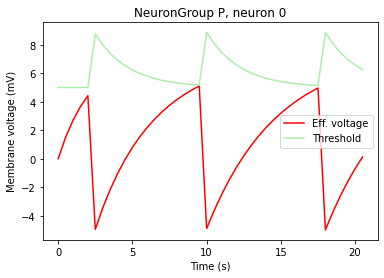

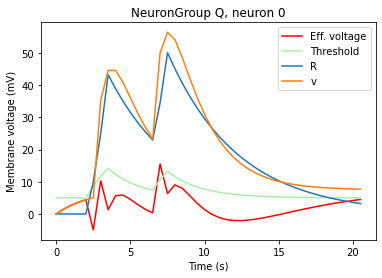

In [13]:
plt.plot(stmPv.t/ms, (stmPv.v[0]-stmPr.r[0])/mV, color="#ff0000", label='Eff. voltage')
plt.plot(stmPtheta.t/ms, stmPtheta.theta[0]/mV, color="#aaeeaa", label='Threshold')
title('NeuronGroup P, neuron 0')
xlabel('Time (s)')
ylabel('Membrane voltage (mV)')
legend()
show()

plt.plot(stmQv.t/ms, (stmQv.v[0]-stmQr.r[0])/mV, color="#ff0000", label='Eff. voltage')
plt.plot(stmQtheta.t/ms, stmQtheta.theta[0]/mV, color="#aaeeaa", label='Threshold')
plt.plot(stmQtheta.t/ms, stmQr.r[0]/mV, label='R')
plt.plot(stmQtheta.t/ms, stmQv.v[0]/mV, label='v')
# plt.plot(stmQtheta.t/ms, stmQj.j[0]/mV, label='j')

title('NeuronGroup Q, neuron 0')
xlabel('Time (s)')
ylabel('Membrane voltage (mV)')
legend()
show()

In [14]:
print("NeuronGroup P:")
print("  ", len(spmP.i), "spikes occurred in total.")
print("  ", spmP.i)
print("  ", spmP.t)
print("  ", spmP.v)
print("NeuronGroup Q:") # TODO readout out `.i` and `.t` variables does not work here yet
#print("  ", len(spmQ.i), "spikes occurred in total.")
#print("  ", spmQ.i)
print("  ", spmQ.v)
#print("  ", spmQ.t)
print("  ", spmQ.v.shape)

NeuronGroup P:
   9 spikes occurred in total.
   <spikemonitor.i: array([0, 1, 2, 0, 1, 2, 0, 1, 2])>
   <spikemonitor.t: array([ 2. ,  2. ,  2. ,  9.5,  9.5,  9.5, 17.5, 17.5, 17.5]) * msecond>
   <spikemonitor.v: array([4.42620737, 4.42620737, 4.42620737, 7.39004349, 7.39004349,
       7.39004349, 7.49517052, 7.49517052, 7.49517052]) * mvolt>
NeuronGroup Q:
   <spikemonitor_1.v: array([ 4.42723485,  4.42723485,  4.42723485,  5.04161121,  5.04161121,
        5.04161121, 35.298803  , 35.298803  , 35.298803  , 23.33960692,
       23.33960692, 23.33960692, 50.05390647, 50.05390647, 50.05390647]) * mvolt>
   (15,)
